# Sarsa vs. Q-Learning

Sarsa and Q-learning are two popular algorithms in the field of reinforcement learning. Both are **control** algorithms, which means that they try to find some policy $\pi$ that allows an agent to act in an environment. At the surface, they seem extremely similar; but, as we will discover in this notebook, there are some key differences between the two.

## Introduction

Central to both algorithms is the idea of an *action-value function*. An action-value function $q^{\pi}(s, a)$ represents the expected discounted cumulative reward that an agent receives when taking an action $a$ in state $s$ and choosing actions using the policy $\pi$ afterwards. If $\pi$ is the optimal policy, then we will denote the respective action-value function as $q^*$. So, intuitively, high action values imply that an action will result in lots of reward in the future. If the agent knew such a function, acting optimally would be simple: just choose the action with the highest q-value at each step!

Unfortunately, an agent isn't being told what this function is, but has to learn it instead. Typically, this is done by iteratively improving some estimate of $q$. Sarsa and Q-learning take slightly different approaches to problem.

### On-policy vs. Off-policy

Sarsa is in the category of *on-policy* algorithms. It tries to learn the action-value function $q^{\pi}$ of some policy $\pi$ while using the same policy to act and collect data. On the other hand, Q-learning is an *off-policy* algorithm. It tries to learn the optimal Q-function $q^*$, but collects data using a completely different policy! The latter is often called the *behavior policy*, while the policy being learned about is typically referred to as the *target policy*.

### Sarsa

The acronym Sarsa comes from the five objects central to the algorithm: $S, A, R, S', A'$, which denote the agent's state and action at some time step $t$, the resulting state and reward, and the action taken at the next time step. The idea behind Sarsa is simple: whenever we observe such a transition, we nudge the action-value estimate $Q(S, A)$ towards the target value $R + \gamma Q(S', A')$. If we stop making progress and $Q(S', A')$ is the same as the target for all states and actions, then the Bellman equation is satisfied and we succesfully found $q^{\pi}$. Otherwise, a theorem based on contraction mappings guarantees that we make progress towards the desired fixed point. To be a little more specific, the Sarsa update is the following:

$$
Q(S, A) \leftarrow Q(S, A) + \alpha \left[ R + \gamma Q(S', A') - Q(S, A) \right]
$$

For people comfortable with programming, here is the main part of the algorithm as Python code. The full implementation can be found [here](https://github.com/christopher-wolff/rlsuite/blob/master/rlsuite/algos/sarsa.py).

```python
Q = np.zeros((num_states, num_actions))
pi = np.full((num_states, num_actions), 1 / num_actions)

for i in range(num_episodes):
    state = env.reset()
    action = np.random.choice(num_actions, p=pi[state])
    done = False
    while not done:
        # Take action and observe next state
        next_state, reward, done, _ = env.step(action)

        # Determine next action and next state
        next_action = np.random.choice(num_actions, p=pi[state])

        # Update Q for the current state
        target = reward + gamma * Q[next_state, next_action]
        Q[state, action] += alpha * (target - Q[state, action])

        # Update policy for the current state
        best_actions = np.where(Q[state] == Q[state].max())[0]
        best_action = np.random.choice(best_actions)
        for a in np.arange(num_actions):
            if a == best_action:
                pi[state, a] = 1 - epsilon + epsilon / num_actions
            else:
                pi[state, a] = epsilon / num_actions

        # Update state and action
        state = next_state
        action = next_action
```

The policy used above is *epsilon-greedy* with respect to $Q$, which means that we typically take the best action, i.e. the one with the highest Q-value, but occasionally, with some small probability $\epsilon$, take a random instead. This ensures sufficient exploration of the environment and makes sure that we don't get stuck on some suboptimal policy.

### Q-Learning

The idea behind Q-learning is quite similar. Again, we repeatedly nudge our value estimates towards a target, but this time, it's $R + \gamma \max_{A'} Q(S', A')$ as opposed to $R + \gamma Q(S', A')$. So, instead of backing up the action we take at the next time step, we consider all possible actions and back up the one with the highest Q-value. So the update is

$$
Q(S, A) \leftarrow Q(S, A) + \alpha \left[ R + \gamma \max_{A'} Q(S', A') - Q(S, A) \right]
$$

This subtle difference has a significant effect: we actually learn about the optimal action-value function $q^*$, no matter which policy we use the obtain our data!

Again, the code is given below, and the full implementation is [here](https://github.com/christopher-wolff/rlsuite/blob/master/rlsuite/algos/qlearning.py).

```python
Q = np.zeros((num_states, num_actions))
pi = np.full((num_states, num_actions), 1 / num_actions)

for i in range(num_episodes):
    state = env.reset()
    action = np.random.choice(num_actions, p=pi[state])
    done = False
    while not done:
        # Take action and observe next state
        next_state, reward, done, _ = env.step(action)

        # Determine next action and next state
        next_action = np.random.choice(num_actions, p=pi[state])

        # Update Q for the current state
        target = reward + gamma * Q[next_state, next_action]
        Q[state, action] += alpha * (target - Q[state, action])

        # Update policy for the current state
        best_actions = np.where(Q[state] == Q[state].max())[0]
        best_action = np.random.choice(best_actions)
        for a in np.arange(num_actions):
            if a == best_action:
                pi[state, a] = 1 - epsilon + epsilon / num_actions
            else:
                pi[state, a] = epsilon / num_actions

        # Update state and action
        state = next_state
        action = next_action
```

## Experiments

To demonstrate some of the key differences between these two seemingly similar algorithms, we will run a simple experiment. The task we will compare the algorithms with is called *Cliff Walking*.

The problem is the following: we live on a 4 by 12 grid, starting in the bottom left corner. At each step, we can move up, down, left, or right to an adjacent grid cell. The goal is to get to the cell in the bottom right corner. If we do so successfully, the episode ends. At each time step, we receive a reward of $-1$ to encourage reaching the goal as quickly as possible. This seems simple, but there is a catch: the cells at the bottom, between the start and the goal, act like a cliff -- if we step onto them, we "fall" and receive a reward of $-100$. If we fall or reach the goal, the episode terminates and we start over.

<img src="imgs/cliffwalking.png" style="width: 500px"/>

<center> Image credit: Sutton & Barto (2018) </center>

As the figure shows, there is a safe path and an optimal path. The safe path avoids getting too close to the cliff and is therefore slightly longer than the optimal path. Let's test out the two algorithms and see how they do!

We'll run each algorithm for 500 episodes and repeated the experiment 10 times. We also add the additional restriction that episodes terminate after 500 steps if they haven't ended until then, just so that the agent doesn't get stuck in an episode forever.

The Sarsa implementation in RL Suite uses an epsilon-greedy policy, and so does the behavior policy used for Q-learning. We'll use the same learning rate, exploration rate, and discount factor for both experiments so that the results are comparable.

In [1]:
import os
import time
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gym.envs.registration import register

from rlsuite.algos import qlearning
from rlsuite.algos import sarsa
from rlsuite.utils import load_data

In [2]:
BASE_LOG_DIR = '/tmp/experiments'
NUM_EPISODES = 1000
NUM_SEEDS = 10
ALPHA = 0.1    # the learning rate
EPSILON = 0.05 # the exploration rate
GAMMA = 0.99   # the discount factor

In [3]:
register(
    id='CliffWalking-v1',
    entry_point='gym.envs.toy_text:CliffWalkingEnv',
    max_episode_steps=500,
)
env_fn = lambda: gym.make('CliffWalking-v1')

In [4]:
for seed in range(NUM_SEEDS):
    _, qlearning_policy = qlearning(
        env_fn=env_fn,
        alpha=ALPHA,
        epsilon=EPSILON,
        gamma=GAMMA,
        num_episodes=NUM_EPISODES,
        data_dir=os.path.join(BASE_LOG_DIR, 'qlearning', f'run{seed}'),
        seed=seed,
    )
    _, sarsa_policy = sarsa(
        env_fn=env_fn,
        alpha=ALPHA,
        epsilon=EPSILON,
        gamma=GAMMA,
        num_episodes=NUM_EPISODES,
        data_dir=os.path.join(BASE_LOG_DIR, 'sarsa', f'run{seed}'),
        seed=seed,
    )

Since Q-learning is an off-policy algorithm, RL Suite stores the results slightly differently than for Sarsa. It saves two statistics files -- one for the behavior policy and one for the target policy. The following snippet shows how to load the statistics and combine them into a single dataframe.

In [5]:
qlearning_train_data = load_data(os.path.join(BASE_LOG_DIR, 'qlearning'), file_name='train_statistics.tsv')
qlearning_eval_data = load_data(os.path.join(BASE_LOG_DIR, 'qlearning'), file_name='eval_statistics.tsv')
sarsa_data = load_data(os.path.join(BASE_LOG_DIR, 'sarsa'))

data = pd.concat(
    objs=[qlearning_train_data, qlearning_eval_data, sarsa_data],
    keys=['qlearning_behavior', 'qlearning_target', 'sarsa'],
    names=['experiment'],
)

In order to make the data a bit easier to visualize, we'll apply some smoothing to it using a moving average filter.

In [6]:
data['episode_return_smooth'] = data['episode_return'] \
    .groupby(level=['experiment', 'run'], group_keys=False) \
    .rolling(window=10) \
    .mean()
data.reset_index(level='experiment', inplace=True)

Now we can plot the result and see how the algorithms compare.

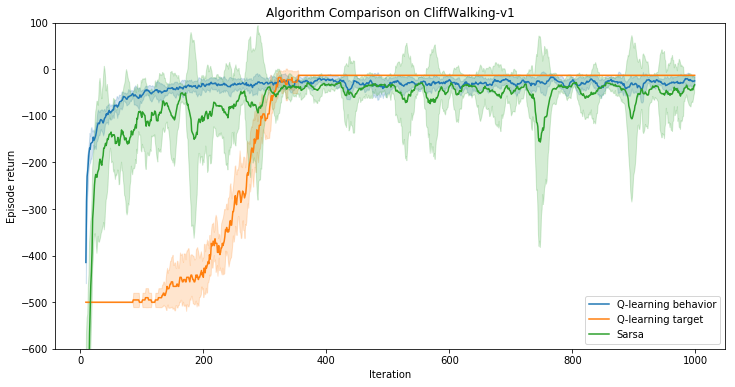

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='iteration', y='episode_return_smooth', hue='experiment', ci='sd')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(loc='lower right', handles=h[1:], labels=['Q-learning behavior', 'Q-learning target', 'Sarsa'])
plt.title('Algorithm Comparison on CliffWalking-v1')
plt.xlabel('Iteration')
plt.ylabel('Episode return')
plt.ylim(-600, 100)
plt.show()

These results may seem a little bit unexpected at first. For the first ~300 episodes, the Q-learning target policy is much worse than the Q-learning behavior policy. But how can this be? If we think back to the task description, we receive a reward of $-1$ per time step, and $-100$ for falling into the cliff. After initializing the Q-table with zeros, the agent quickly learns that falling into the cliff is bad and thus move away from it. As a result, the agent will wander around aimlessly, though it may not have learned about the goal state yet, since discovering it requires a specific series of random, improbable events. Doing so accumulates negative rewards, up until the `max_episode_steps` limit of 500. Meanwhile, the behavior policy quickly falls into the cliff by accident, resulting in a quick termination with $-100$ reward.

After a while, though, we see that the Q-learning target policy outperforms both the behavior policy as well as Sarsa. Sarsa appears to converge a certain sub-optimal policy and then stop improving. This makes sense! After all, Q-learning should be converging to the optimal policy, whereas Sarsa should only converge to the optimal epsilon-greedy policy.

Let's see the Q-learning target policy and the final Sarsa policy in action to see how they behave.

In [8]:
NUM_ACTIONS = 4
env = gym.make('CliffWalking-v1')
state = env.reset()
env.render()
done = False
while not done:
    action = np.random.choice(NUM_ACTIONS, p=qlearning_policy[state])
    state, reward, done, _ = env.step(action)
    env.render()
env.close()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o

As we can see, Q-learning takes the risky but optimal path to the goal! How about Sarsa?

In [9]:
NUM_ACTIONS = 4
env = gym.make('CliffWalking-v1')
state = env.reset()
env.render()
done = False
while not done:
    action = np.random.choice(NUM_ACTIONS, p=sarsa_policy[state])
    state, reward, done, _ = env.step(action)
    env.render()
env.close()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  x

Sarsa learns to take the safe, suboptimal path! Why is this? Why do the two algorithms that are so similar on the surface learn completely different policies? To answer this question, we have to think back to the respective update rules.

Suppose the Sarsa agent finds itself in a state at the edge of the cliff. Since it's using an epsilon-greedy policy, there will always be a small chance that the next action results in it falling off. Thus, the update target $R + \gamma Q(S', A')$ will be a large negative value, and the action-value of the border state-action pair is updated in that direction. As a result, the agent tries to avoid these "risky" states, because it knows that under the epsilon-greedy policy, there is a chance that it will fall off.

On the other side, Q-learning is also using an epsilon-greedy policy to explore. So why wouldn't it also learn to avoid the border states along the optimal path? The reason for this is rooted within the Q-learning update. The target is the *maximum* Q-value in the successor state, not the chosen one. Thus, even if one of the actions in the next state lead the agent to fall off the cliff, it can back up the value of another action! It doesn't matter how often the agent falls off in a border state, as long as one of the other actions has a good value.

Note, however, the downside to this. Even if the behavior policy for Q-learning was extremely exploration-oriented, it would still wander along the edge and not "care" about the negative rewards that would frequently come as a result. Suppose that instead of this toy task, the algorithm was applied to a real-world problem where negative rewards could represent money spent. This would be extremely costly! Admittedly, this is not shown too well in this experiment, because the behavior policy in Q-learning still achieves better results than Sarsa, but using a higher epsilon value in the Q-learning experiment would show this nicely. Try it out!

Lastly, note that we can also use Sarsa to learn the optimal policy. To do this, we have to decay epsilon over time. Choosing a decay schedule can often be tricky, though, because it's difficult to get a feel for how quickly this should be done.

## Conclusion

We took a look at two popular reinforcement learning algorithms and compared them on a classic toy problem. Hopefully, this uncovered some of the key difference between the two so superficially similar algorithms, which differ only in the update target.

So, why would one prefer Sarsa over Q-learning and vice versa? If we only care about an optimal final policy and not about any negative rewards during training, Q-learning is typically the way to go. If, however, negative rewards are very costly, Sarsa comes out on top.

For further reading, check out the following blog posts.

- [TD, Sarsa, Q-learning, Expected Sarsa](https://towardsdatascience.com/reinforcement-learning-temporal-difference-sarsa-q-learning-expected-sarsa-on-python-9fecfda7467e)
- [Introduction to various RL algorithms](https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287)